# Stressed VaR calibration

## A quick introduction

This jupyter notebook will demonstrate how Atoti can help to analyse and explore **Value-at-Risk** across observation windows:

- [Value-at-Risk](https://www.investopedia.com/terms/v/var.asp) is an example of a non-linear aggregation: we will estimate Value-at-Risk by taking an empirical quantile from portfolio's simulated P&L vector - and a quantile for a portfolio is not equal to the sum of quantiles of it's sub-portfolios.
- The measures for the **period of stress** will scan through all the sliding historical windows to find the maximum VaR and the corresponding period.
- We will be able to expand data and interactively recompute the VaRs as relevant to the portfolios.

This tool can be particularly useful for clients looking to **recalibrate the period** of significant stress relevant to their portfolio, for instance, from the **Global Financial Crisis of 2008** to the **Coronavirus Market Crash of 2020**. Financial organisations have to report to the regulator the chosen stress period and the rationale for this choice. Please refer to the EBA Guidlines to read more about this requirement: https://eba.europa.eu/sites/default/documents/files/documents/10180/104547/cce3fca5-67ca-4513-a540-67942204ef43/EBA-BS-2012-78--GL-on-Stressed-VaR-.pdf?retry=1 


<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-calibration" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Atoti table" /></a></div>  

We will focus on the step-by-step implementation of an analytical cube for the rolling VaR use case in Atoti. It will be possible to explore portfolio in the app as illustrated with this gif:

![Stressed VaR app preview](https://data.atoti.io/notebooks/stressed-var-calibration/img/app-preview.gif)


# Importing libraries

We will be using Atoti and pandas today.

In [1]:
import atoti as tt
import pandas as pd

# Sample data overview

For the purposes of this demonstration, we'll use a simplified data model that can be adjusted for a real-life use case. The datastores that we'll need include:

* Positions: books, stock positions market values in USD (long and short positions).
* Historical returns and prices: vectors of stock prices and daily percentage changes. We will be multiplying positions market values by daily percentage changes to obtain a simulated historical P&L for the demonstration. **As a best practice we load the returns and prices as vectors. This reduces the size of the files and memory requirement, and speeds up the calculations.**
* Business calendar with the list of historical/business dates.

The first two data stores can be replaced with full revaluation P&L vectors from a risk system. 

You can also enrich the data with other dimensions and attributes. For instance: Product Hierarchies, Risk Factor attributes, Legal entities.

# Creating an Atoti session and loading data

In [2]:
# Starting Atoti session
session = tt.Session.start(tt.SessionConfig(user_content_storage="content"))

# URL to Atoti's UI:
session.link

http://localhost:50017

Let's load historical data into a store from a csv file. By setting `array_sep`, Atoti will recognize the input data is in vectorized format.

💡 **Note:** Read more about the supported input data sources at https://docs.atoti.io/.

In [3]:
market_data = session.read_csv(
    "s3://data.atoti.io/notebooks/stressed-var-calibration/stock_price_returns.csv",
    keys=["Stock"],
    table_name="StockData",
    array_separator=";",
    buffer_size_kb=256,
)

market_data.head(3)

,Returns,Prices
Stock,,
EOG,"[0.001013001435978822, -0.03757058422244541, 0...","[35.61472702026367, 34.27666091918945, 35.0515..."
OXY,"[-0.011864790981753304, -0.011183002663104902,...","[25.641834259033203, 25.35508155822754, 26.505..."
LUKOY,"[0.0195919993640441, 0.004003175727552932, 0.0...","[32.09617614746094, 32.22466278076172, 32.3274..."


Let's load the positions:

In [4]:
positions = session.read_csv(
    "s3://data.atoti.io/notebooks/stressed-var-calibration/positions_snapshot.csv",
    keys=["Book", "Stock", "TradeId"],
    table_name="Positions",
    data_types={"MarketValueUSD": tt.type.DOUBLE},
)

positions.head(3)

Portfolio  MarketValueUSD
Book    TradeId        Stock                          
Indices Trade_0f062c06 ^DJI         US      278.852596
        Trade_0f162e12 ^DJI         US      193.938693
        Trade_0f1aa910 ^DJI         US      262.129051

In [5]:
# Joining the market_data table to the position table.
positions.join(market_data)

# Creating an OLAP cube

In [6]:
cube = session.create_cube(positions, "Historical VaR Cube", mode="auto")
h = cube.hierarchies
l = cube.levels
m = cube.measures
cube

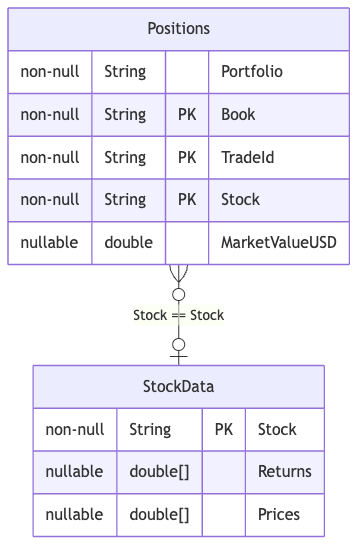

In [7]:
session.tables.schema

The default aggregation functions created at this step allow to display position's market values - see measure `MarketValueUSD.SUM`. We'll be adding user-defined aggregation functions in addition to the default ones.

# Business hierarchies

Users can create multi-level hierarchies to expand data order natural to their area. For example, let's put Books under Portfolios to create a two-level Business Hierarchy:

In [8]:
h["Portfolio Structure"] = [l["Portfolio"], l["Book"]]

In [9]:
h

{('Positions', 'TradeId'): <atoti.hierarchy.Hierarchy object at 0x12d446950>, ('Positions', 'Stock'): <atoti.hierarchy.Hierarchy object at 0x12d445050>, ('Positions', 'Book'): <atoti.hierarchy.Hierarchy object at 0x12d48f190>, ('Positions', 'Portfolio'): <atoti.hierarchy.Hierarchy object at 0x12d48f090>, ('Positions', 'Portfolio Structure'): <atoti.hierarchy.Hierarchy object at 0x12d48fe50>}

 We are using the multi-level `Portfolio Structure` to expand portfolio's Market Value.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
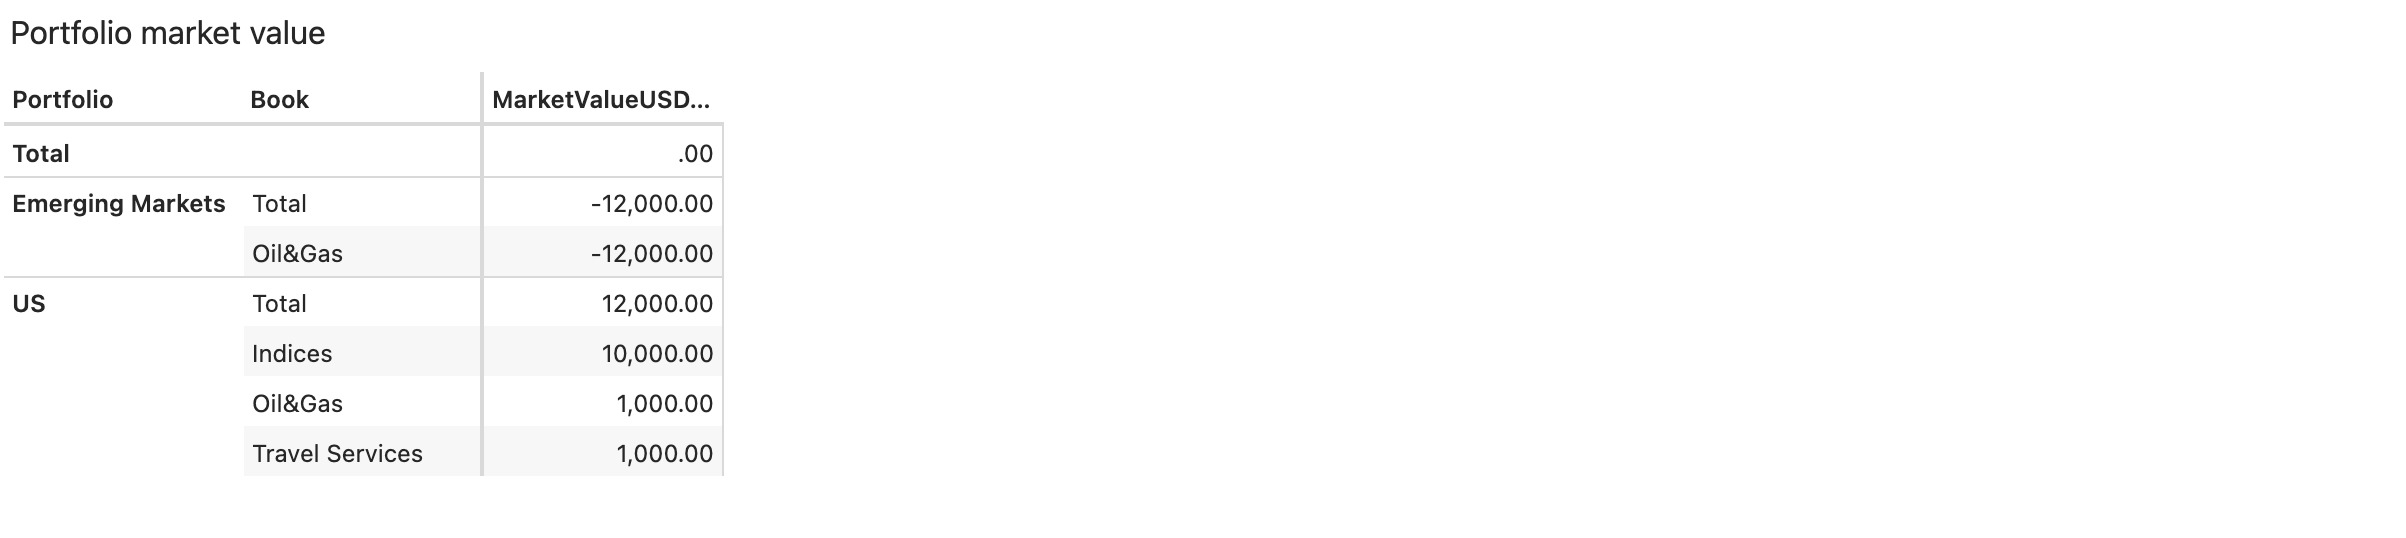

In [10]:
session.widget

# Custom measure for the VaR vector

In our simple example, we multiply the positions market values - `MarketValueUSD.SUM` by the stock returns - `Returns.VALUE` for each name, and then summing them up across positions to obtain the historical VaR vectors. This step is not necessary if P&L vectors are delivered by a risk system. 

In [11]:
m["Returns.VALUE"] = tt.agg.single_value(market_data["Returns"])
m["P&L Vector"] = tt.agg.sum(
    m["MarketValueUSD.SUM"] * m["Returns.VALUE"], scope=tt.OriginScope({l["Stock"]})
)

The `P&L vector` is a technical measure displaying all P&L values in one cell - it is not a user friendly presentation of the simulated P&Ls. We will create a VaR aggregation from the vector and also we'll make it possible to view individual scenarios. Continue reading to learn how. 

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
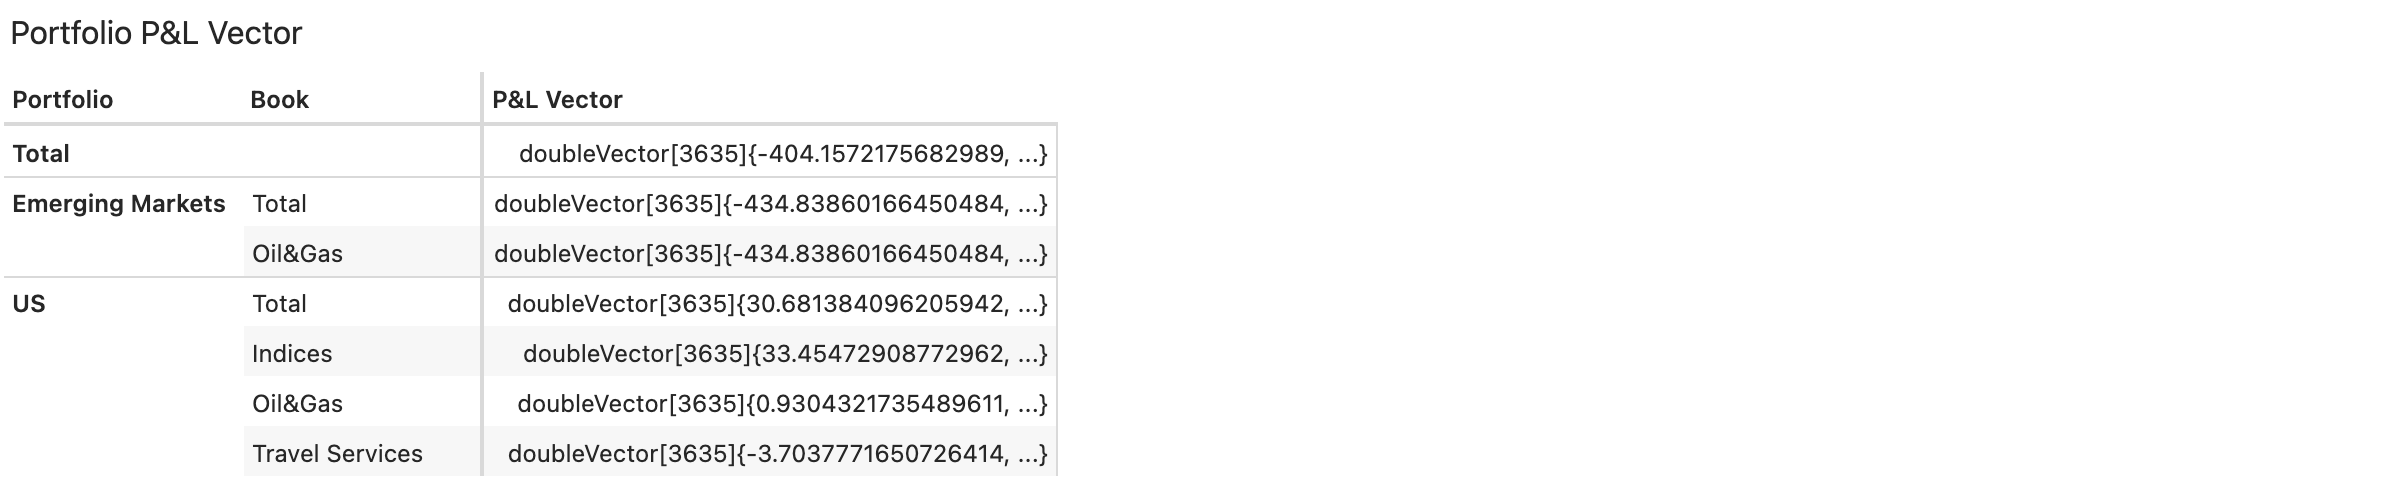

In [12]:
session.widget

# View P&L scenarios by Date - "Vector Expansion"

With the `P&L Vector` we can view P&L in vectorized format which is not user-friendly. Let's create a hierarchy that will allow to display P&L value by historical date - this approach is referred to as vector expansion in Atoti.

In [13]:
calendar = pd.read_csv(
    "http://data.atoti.io/notebooks/stressed-var-calibration/business_calendar.csv"
)["Date"]

cube.create_parameter_hierarchy_from_members(
    "Historical Dates",
    list(calendar),
    index_measure_name="Date Index",
)
# Setting the hierarchy to non-slicing, as required by
# the max_member aggregation function - see later - this behavior might change in future versions.
h["Historical Dates"].slicing = False

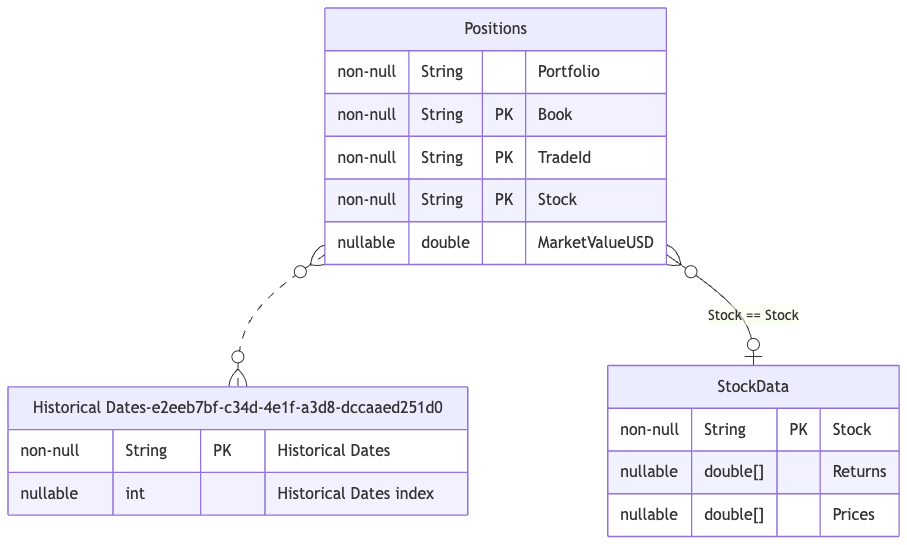

In [14]:
session.tables.schema

Regular hierarchies are created from the stores where the original dataset have been loaded. On the other hand, **parameter hierarchies** are created on the fly based on any set of data, even unrelated to the original dataset. The members of that hierarchy can be used for any calculations or filtering and behave as a regular hierarchy from user standpoint.

In [15]:
m["Prices.VALUE"] = tt.agg.single_value(market_data["Prices"])
# This new measure will pick an element from the VaR vector:
m["P&L at date"] = m["P&L Vector"][m["Date Index"]]
m["P&L at date"].formatter = "DOUBLE[#,##0.#]"
m["Return at date"] = m["Returns.VALUE"][m["Date Index"]]
m["Return at date"].formatter = "DOUBLE[#,##0.#%]"
m["Price at date"] = m["Prices.VALUE"][m["Date Index"]]

Open this bookmark that makes use of the `P&L at date` and the `Return at date` measures to **zoom in the tail scenarios** across stock for example:

In [16]:
# putting the above information in a dashboard.
session.link / "#/dashboard/226"

http://localhost:50017/#/dashboard/226

# Creating Sliding Windows

We want to compute VaRs for different observation windows to see which period would lead to the most conservative VaR for our current portfolio. Such a "worst" window will be a good candidate for the Stressed VaR calibration and will be a focus for further analysis and decomposition.

In [17]:
# # Lets create a measure for the observation window length:
lookback_windows = cube.create_parameter_simulation(
    "Lookback Window",
    measures={"Lookback Window": 260},
    base_scenario_name="260 days",
)

In [18]:
# This is a measure picking a subset of scenarios preceeding and including each observation date,
# i.e. historical rolling window:
m["P&L Sub-Vector"] = m["P&L Vector"][
    m["Date Index"] - m["Lookback Window"] + 1 : m["Date Index"] + 1
]

The Sub-Vector measure requires having historical dates in the view. 

Now for each desired scope, the `P&L Sub-Vector` measure will pick 260 most recent values from the `P&L vector`. The below view is filtered for the 3 most recent historical dates. This result is not suitable for human consumption, but is still shown here for illustration purposes - each vector is a sub-vector shifted 1 day forward.

In [ ]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

# Adding Sliding VaR measure

In this notebook, we'll apply a simple quantile function to the subvector to obtain a VaR estimate.

In [ ]:
m["1d 99% VaR Sliding"] = tt.math.abs(tt.array.quantile(m["P&L Sub-Vector"], 0.01))

In [ ]:
# This measure is computing the worst VaR value:
m["Worst VaR"] = tt.agg.max(
    m["1d 99% VaR Sliding"], scope=tt.OriginScope({l["Historical Dates"]})
)
m["Worst VaR"].formatter = "DOUBLE[#,##0.#]"
# This measure is computing the worst VaR window (identified by the end date):
m["Worst VaR Period End"] = tt.agg.max_member(
    m["1d 99% VaR Sliding"], l["Historical Dates"]
)

In the following cell, we are visualising the `Worst VaR` and the end of the corresponding period. By bringing the business structure into the view, we can interactively re-evaluate these metrics.

In [ ]:
session.widget

As we want to display the `Worst VaR` on charts, we are creating a "parent_value" for this measure. It will display the `Worst VaR` calculated across all observation windows - next to each of the historical dates.

In [ ]:
m["Worst VaR propagate to each date"] = tt.parent_value(
    m["Worst VaR"], degrees={h["Historical Dates"]: 1}, apply_filters=True
)

The default value for the `apply_filters` parameter in the `parent_value` function in Atoti is set to `False`, which means that the measure will not respect any filters in the view: the `Worst VaR` would be computed across all positions and observation windows no matter what book we have selected, and propagated back to historical dates. We want the `Worst VaR` measure to respect the filters, for instance, on Books or Trades, hence setting the `apply_filters` to `True`.

As expected, VaR chart is step-wise and goes up and down every time extreme scenarios leave and enter the observation window - let's **visualize sliding VaR by historical observation periods**:

In [ ]:
session.widget

We can explore the metrics interactively, in a dashboard. Open the following link and expand portfolios - the `Worst VaR` will recompute interactively - there seems to be a new peak for the "US" portfolio, coming from the "Oil&Gas" and "Travel Services" books. 

In [ ]:
# put the above information in a dashboard
session.link / "#/dashboard/aa4"

# What-If on different lookback setting

You can experiment with the observation window length to evaluate a potential impact of switching to a shorter window on the risk numbers. The stressed VaR framework requires a 1-year period, but you may want to switch to a shorter window for the current VaR analysis.

Let's create a what-if simulation and changing the `Lookback Window` measure to shorter and longer lengths. Now the different `Lookback Windows` scenarios are available in the UI for analysis. As expected, the shorter the observation window, the faster VaR metric reacts to changes in market volatility. 

In [ ]:
# Lets create scenarios for the measure for the observation window length:
lookback_windows += ("10 days", 10)
lookback_windows += ("120 days", 120)
lookback_windows += ("2600 days", 2600)

In [ ]:
session.widget

<div style="text-align:center"><a href="https://www.atoti.io/?utm_source=gallery&utm_content=var-calibration" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Atoti table" /></a></div>